### 1.1 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시

- 데이터는 총 41024건이며, 이 데이터에는 348명의 CustomerID가 존재하였다.
- M 컬럼 생성에 필요한 Amount가 음수인 1172건은 이상치로 판단되어 제거하였다.
- F 컬럼과 M 컬럼을 생성하여 데이터에 추가하였다.  
- F, M 컬럼 모두 중앙값에 비해 max가 매우 큰 수치를 갖고 있어 높은 왜도를 갖고 있다.
- 히스토그램으로 확인한 결과 작은 곳에 값이 집중되어 있는 것을 볼 수 있었다.

데이터 총 수: 41024 CustomerID의 종류 개수: 348
  InvoiceNo StockCode                    Description  Quantity  \
0    565857     84879  ASSORTED COLOUR BIRD ORNAMENT        16   
1    560452     22432        WATERING CAN PINK BUNNY         6   
2    578509     22492        MINI PAINT SET VINTAGE         36   
3    579345     22728      ALARM CLOCK BAKELIKE PINK         8   
4    564039     21731  RED TOADSTOOL LED NIGHT LIGHT        12   

        InvoiceDate  UnitPrice  CustomerID  Country  
0    9/7/2011 14:13       1.69     14911.0     EIRE  
1    7/19/2011 9:51       1.95     12682.0   France  
2  11/24/2011 13:17       0.65     12705.0  Germany  
3  11/29/2011 11:46       3.75     12727.0   France  
4   8/22/2011 12:40       1.65     12645.0  Germany  
              count          mean          std      min       25%       50%  \
Quantity    41024.0     19.425507    44.253624   -480.0      4.00     10.00   
UnitPrice   41024.0      4.652498    45.383856      0.0      1.25      1.95   
Cust

array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'UnitPrice'}>],
       [<Axes: title={'center': 'CustomerID'}>, <Axes: >]], dtype=object)

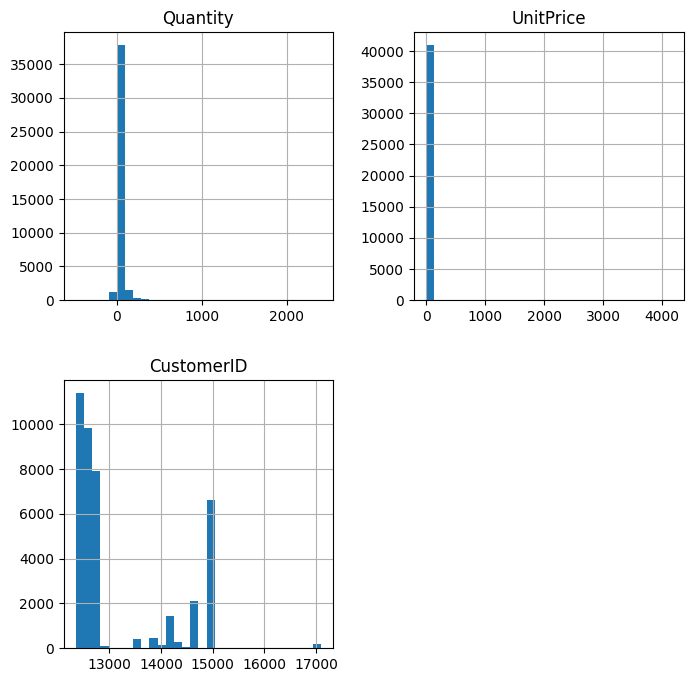

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_url = 'https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv'
df = pd.read_csv(file_url)
print('데이터 총 수:', df.shape[0],
      'CustomerID의 종류 개수:', df['CustomerID'].nunique())
print(df.head())
print(df.describe().T)
df.hist(bins=30, figsize=(8,8))

In [13]:
dfFM = pd.DataFrame()
df['Amount'] = df['Quantity'] * df['UnitPrice']
outlier = df[df['Amount'] <= 0].index
df2 = df.drop(outlier, axis=0)
dfFM['F'] = df2.groupby('CustomerID')['InvoiceNo'].count()
dfFM['M'] = df2.groupby('CustomerID')['Amount'].sum()
print('삭제 데이터 건 수:', len(outlier))
dfFM.info()

삭제 데이터 건 수: 1172
<class 'pandas.core.frame.DataFrame'>
Index: 345 entries, 12348.0 to 17097.0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F       345 non-null    int64  
 1   M       345 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.1 KB


In [10]:
dfFM.describe().T

,count,mean,std,min,25%,50%,75%,max
F,345.0,115.513043,343.419645,2.0,23.00,50.0,108.00,5675.00
M,345.0,4145.790174,19255.241859,63.0,460.89,1035.8,2794.51,280206.02


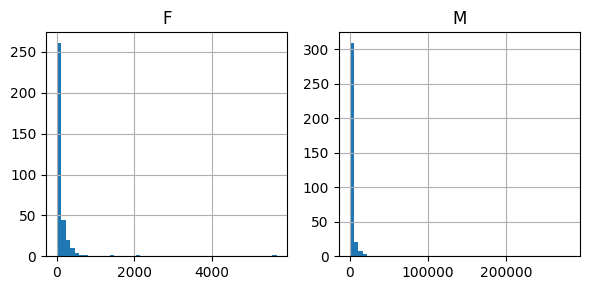

In [14]:
dfFM.hist(bins=50, figsize=(6, 3), layout=(1, 2))
plt.tight_layout()
plt.show()

## 1.2 F, M feature 기반으로 군집분석 실시, 필요시 이상값 보정

1. 왜도가 심한 것을 보정하기 위해 로그변환을 실시하였다.
- 로그변환은 큰 값을 작게 만드는 효과가 있다.
- 로그변환 결과를 히스토그램으로 확인한 결과 정규분포와 비슷한 형태로 변환된 것을 확인할 수 있다.
- DBSCAN을 사용하여 밀도기반 군집을 만들 결과 군집으로 만들어 지지 않는 이상치가 20개 발견되었다.
- 그러나 실루엣 계수가 좋지 않음 (0.437)
- 군집별로 나누어 보았을 때에도 0.473 정도로 아주 높은 것은 아니었음

2. 밀도 기반 군집이므로 MinMaxScaler를 사용하였다
- MinMaxScaler는 모든 데이터의 값을 0-1 사이의 값으로 변경한다.
- DBSCAN을 사용하여 밀도기반 군집을 만들 결과 군집으로 만들어 지지 않는 이상치가 2개 발견되었다.
- 실루엣 계수 또한 좋은 것을 볼 수 있다. (0.971)

- 군집에 포함되지 않은 데이터 확인을 통해 이유를 확인하는 것이 필요해 보인다.

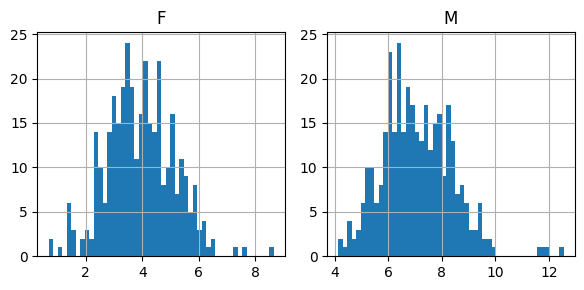

In [17]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
dfFM2 = np.log(dfFM)
dfFM2 = pd.DataFrame(dfFM2, columns=['F', 'M'])
dfFM2.hist(bins=50, figsize=(6, 3), layout=(1, 2))
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import silhouette_score, silhouette_samples
model = DBSCAN()
cluster = model.fit_predict(dfFM2)
result = pd.Series(cluster).value_counts().sort_index()
print(result)
dfFM2['cluster'] = cluster
dfFM2['silhouette_coeff'] = silhouette_samples(dfFM2, cluster)
cluster_score = dfFM2.groupby('cluster')[['silhouette_coeff']].mean()
score = silhouette_score(dfFM2, cluster)
print(cluster_score)
print(f'\nlog 변환 실시 후 군집에 대한 실루엣 계수 : {score:.3f}')
outlier1 = dfFM[dfFM2['cluster']==-1]

-1     20
 0    325
Name: count, dtype: int64
         silhouette_coeff
cluster                  
-1              -0.157659
 0               0.462186

log 변환 실시 후 군집에 대한 실루엣 계수 : 0.438


In [19]:
dfFM3 = MinMaxScaler().fit_transform(dfFM)
dfFM3 = pd.DataFrame(dfFM3, columns=['F', 'M'])
model = DBSCAN()
cluster = model.fit_predict(dfFM3)
result = pd.Series(cluster).value_counts().sort_index()
print(result)
dfFM3['cluster'] = cluster
dfFM3['silhouette_coeff'] = silhouette_samples(dfFM3, cluster)
cluster_score = dfFM3.groupby('cluster')[['silhouette_coeff']].mean()
score = silhouette_score(dfFM3, cluster)
print(cluster_score)
print(f'\nMinMaxScaling 실시 후 군집에 대한 실루엣 계수 : {score:.3f}')
outlier2 = dfFM[cluster==-1]

-1      2
 0    343
Name: count, dtype: int64
         silhouette_coeff
cluster                  
-1               0.456047
 0               0.982323

MinMaxScaling 실시 후 군집에 대한 실루엣 계수 : 0.978


## 1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

실루엣 계수(Silhouette Coefficient)
- 각각의 데이터가 해당 데이터와 같은 군집 내의 데이터와는 얼마나 가깝게 군집화가 되었고,
- 다른 군집에 있는 데이터와는 얼마나 멀리 분포되어 있는지를 나타내는 지표이다.
- 실루엣 계수가 가질 수 있는 값은 -1~1이다.
- 실루엣 계수가 1에 가까울수록 군집화가 잘 되었음을 의미한다.
- 0.5 보다 큰 경우 결과가 타당한 것으로 평가한다.
- log 변환을 통한 경우 이상치 제외한 군집의 실루엣 계수가 0.47 정도로 타당하지 않은 결과이고, MinMaxScaling한 경우는 0.98 정도로 군집화가 잘 되었다고 판단된다.

## 1.4 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

로그 변환을 사용한 것을 사용해 발견한 이상치와 MinMaxScaling을 사용해 발견한 이상치를 분석해 고객에 대한 이상값이 어떤 의미를 갖는지 연구하여 해당 고객에 대해 긍정 또는 부정의 조치를 취하고, 지속적인 관리를 하도록 한다.
- 14646, 14911 고객은 두 가지 방법에서 모두 이상치로 판단된 고객이다.
- 두 고객의 F, M은 다른 고객에 비해 많이 높은 편이므로 특별히 우수 고객으로 관리할 필요가 있다.